In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import EarthLocation, GCRS, CartesianRepresentation, AltAz, SkyCoord, ICRS

from reproject import reproject_interp

In [2]:
import pandas as pd
from glob import glob
import warnings
from tqdm.autonotebook import tqdm
from shapely.geometry import LineString

<ipython-input-2-7f495fa06e00>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
warnings.simplefilter('ignore', wcs.FITSFixedWarning)

In [4]:
def read_cams_observations(fname):
    # Read file
    d = np.loadtxt(fname,
                   skiprows=3,
                   usecols=(0, 1, 2, 3,
                            4, 5, 7, 9,
                            15, 17, 19, 21,
                            23, 25, 31, 32),
                   dtype={"names": ("number", "date", "time", "tbeg",
                                    "tend", "RAinf", "DECinf", "Vinf",
                                    "LatBeg", "LonBeg", "Hbeg", "LatEnd",
                                    "LonEnd", "Hend", "Max-mV", "Int-mV"),
                          "formats": ("i4", "S10", "S11", "f4",
                                      "f4", "f4", "f4", "f4",
                                      "f4", "f4", "f4", "f4",
                                      "f4", "f4", "f4", "f4")})

    # Convert time
    tstr = [f"{d.decode('UTF-8')}T{t.decode('UTF-8')}" for d, t in zip(d["date"], d["time"])]
    t = Time(tstr, format="isot", scale="utc")
    t0 = t + d["tbeg"] * u.s
    t1 = t + d["tend"] * u.s
    
    # Convert radiant and velocity
    vx = -d["Vinf"] * np.cos(d["DECinf"] * u.deg) * np.cos(d["RAinf"]  * u.deg) * u.km / u.s
    vy = -d["Vinf"] * np.cos(d["DECinf"] * u.deg) * np.sin(d["RAinf"]  * u.deg) * u.km / u.s
    vz = -d["Vinf"] * np.sin(d["DECinf"] * u.deg) * u.km / u.s

    # Convert positions
    x0, y0, z0 = EarthLocation(lat = d["LatBeg"] * u.deg,
                               lon = d["LonBeg"] * u.deg,
                               height = d["Hbeg"] * u.km).get_gcrs(obstime=t0).cartesian.xyz

    # Write out
    return Table([d["number"], t.isot, x0, y0, z0, vx, vy, vz, d["tbeg"], d["tend"]],
              names=["number", "t0", "x0", "y0", "z0", "vx", "vy", "vz", "dtmin", "dtmax"])

In [5]:
fitsfiles = sorted(glob("/data1/dijkema/A12_meteor/*.fits"))

In [6]:
fitstimes = Time([fitsfile[26:47] for fitsfile in fitsfiles], format='isot')

In [121]:
fname = "/data1/dijkema/A12_meteor/2020-08-12T23:57:39.1_14B.fits"
number = 333
fname = "/data1/dijkema/A12_meteor/2020-08-12T23:57:41.1_14B.fits"
number = 333
fname = "/data1/dijkema/A12_meteor/2020-08-13T03:02:44.3_16B.fits"
number = 704
fname = "/data1/dijkema/A12_meteor/2020-08-13T02:55:58.6_16B.fits"
number = 696
fname = "/data1/dijkema/A12_meteor/2020-08-13T01:25:48.0_14B.fits"
number = 492

In [8]:
def get_fitsfiles(cams_time, extra=0):
    """Get filenames of time just before CAMS time and the CAMS time itself"""
    index_with_detection = np.argmin(cams_time > fitstimes) + extra # Can be tweaked, maybe -1 or +1
    index_before_detection = index_with_detection - 2 - extra       # Can be tweaked, maybe -1
    assert((Time(fitsfiles[index_with_detection][26:47]) - Time(fitsfiles[index_before_detection][26:47])).to(u.s) < 10*u.s)
    return fitsfiles[index_before_detection], fitsfiles[index_with_detection]

In [14]:
camsdata = pd.read_fwf("../SummaryMeteorLog CAMS Benelux 120820 .txt",
                            index_col=0,
                            header=[0, 1],
                            skip_blank_lines=True,
                            skiprows=[2],
                            skipinitialspace=True)

camsdata.columns = [
    ' '.join(col) if isinstance(col, tuple) else col
    for col in camsdata.columns
]

camsdata["astropytime_beg"] = Time(
    list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])
) + np.array(camsdata["Tbeg sec"]) * u.s
camsdata["astropytime_end"] = Time(
    list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])
) + np.array(camsdata["Tend sec"]) * u.s

camsdata = camsdata.join(pd.read_csv("aartfaac-cams-matches.csv", index_col=0))

In [16]:
cams_numbers_with_trails = camsdata[camsdata["AARTFAAC"] > 1].index

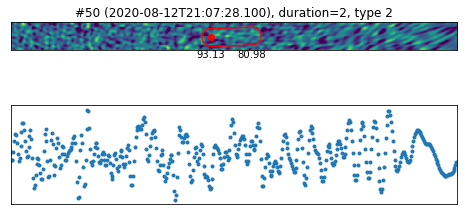

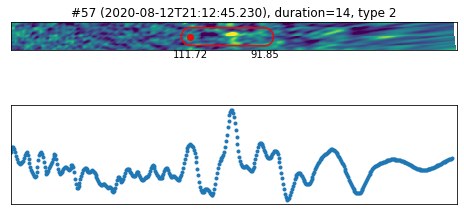

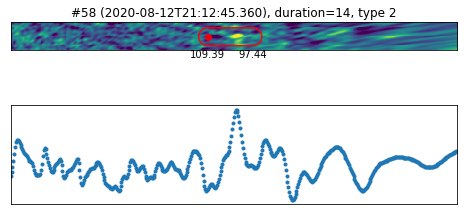

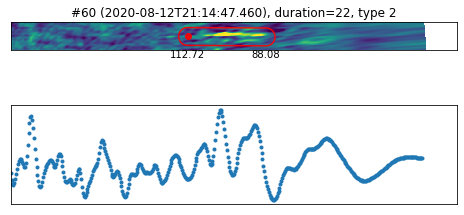

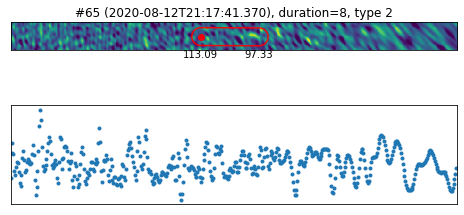

No good times around ['2020-08-12T21:24:05.250']
No good times around ['2020-08-12T21:24:42.710']
No good times around ['2020-08-12T21:24:46.280']


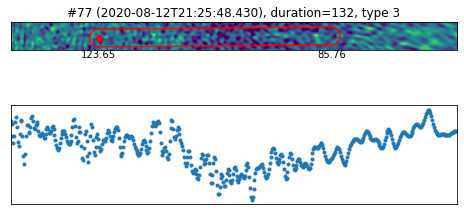

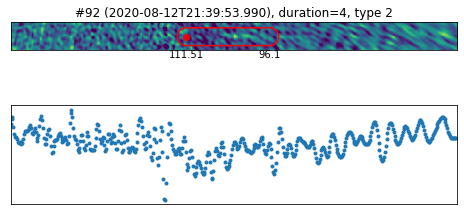

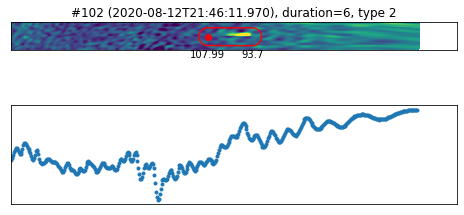

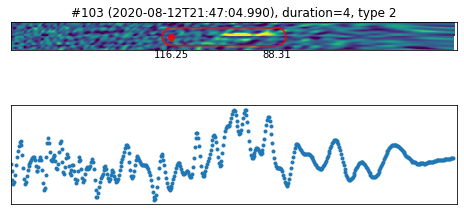

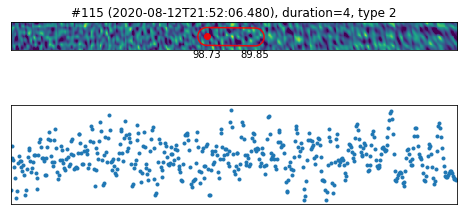

No good times around ['2020-08-12T21:57:18.680']


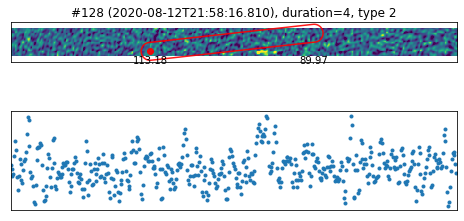

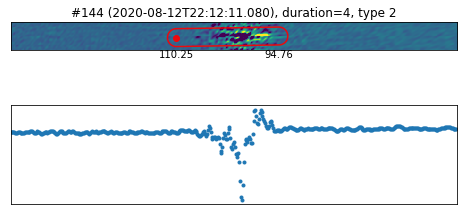

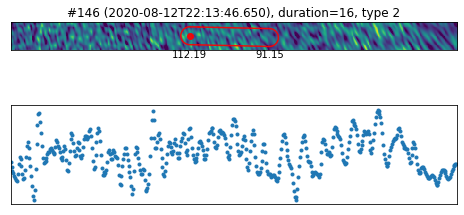

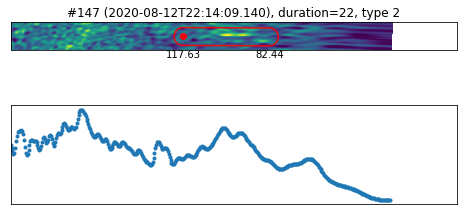

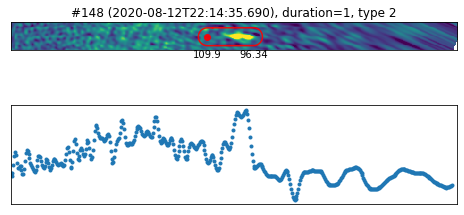

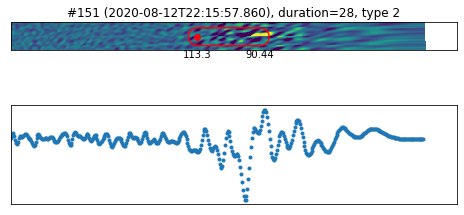

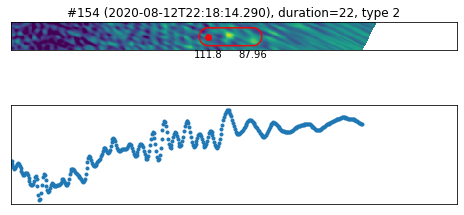

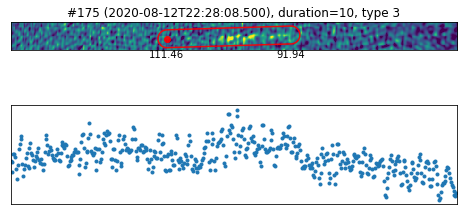

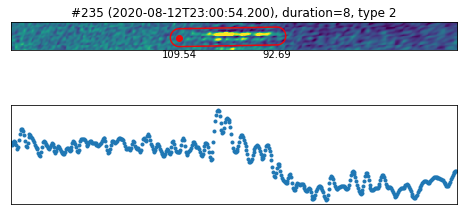

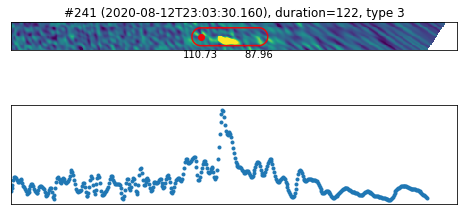

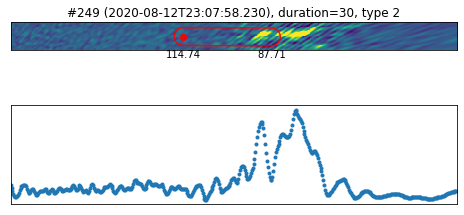

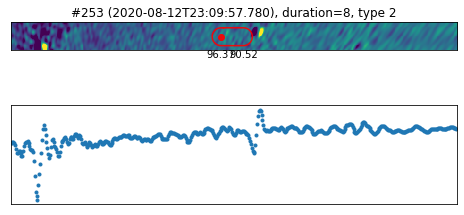

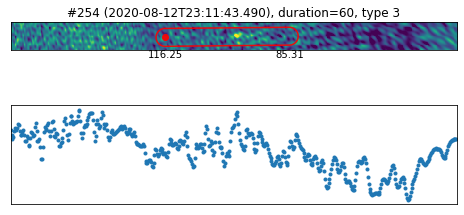

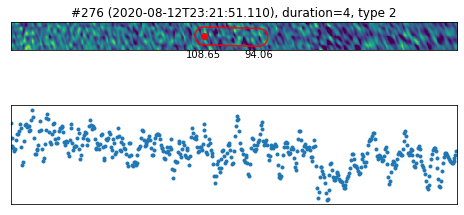

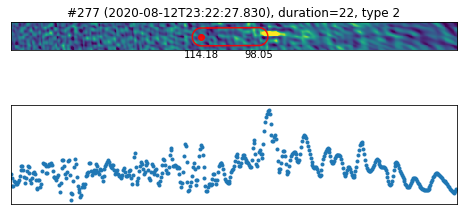

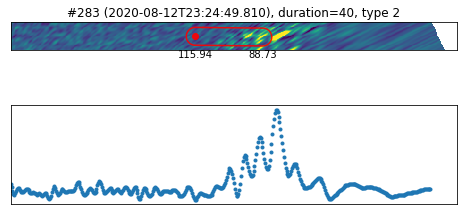

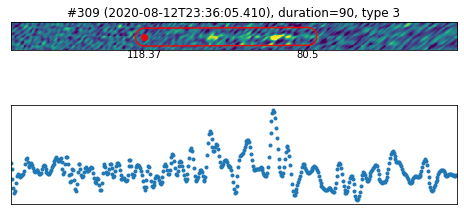

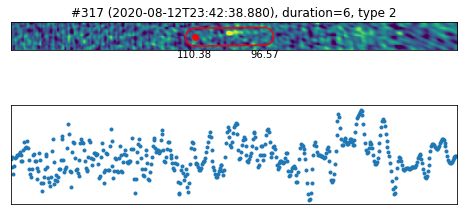

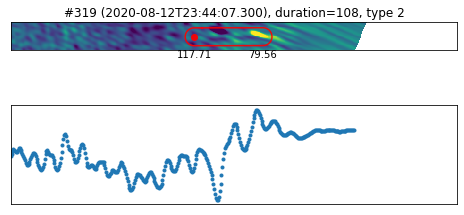

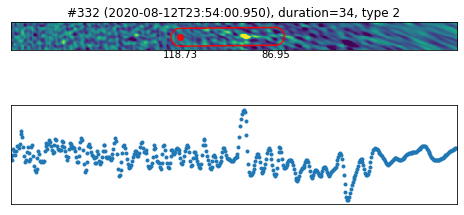

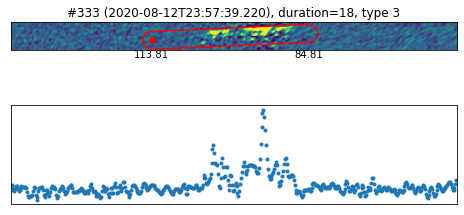

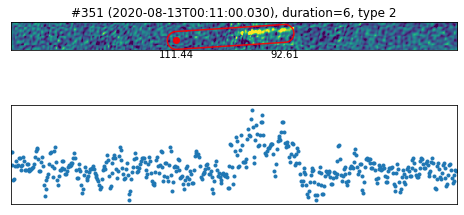

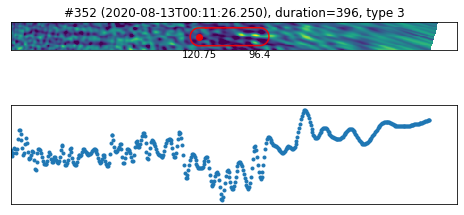

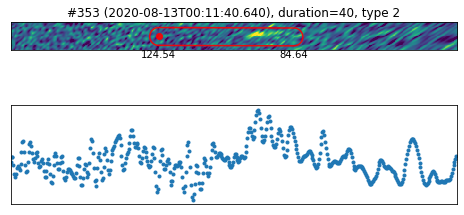

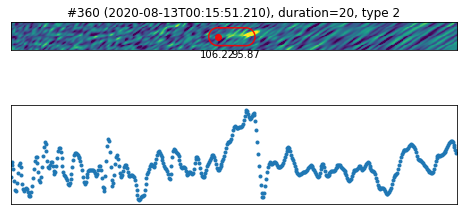

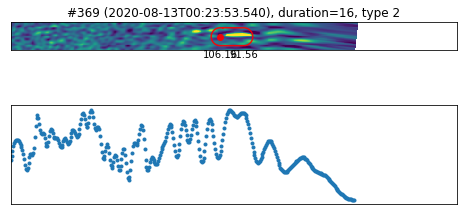

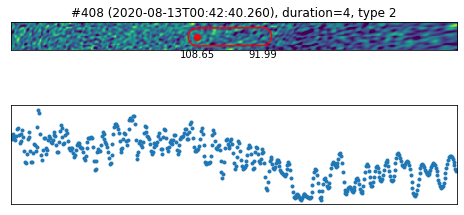

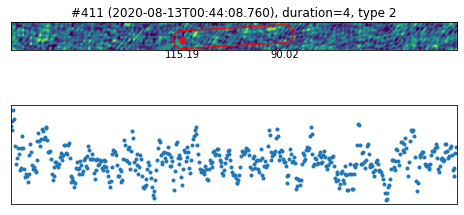

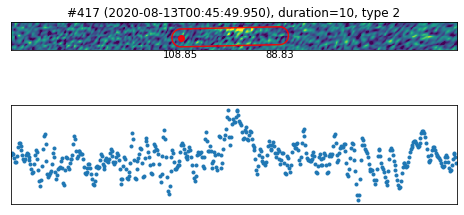

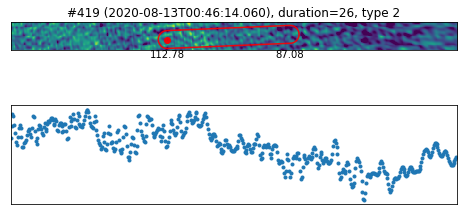

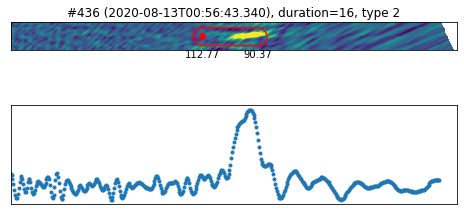

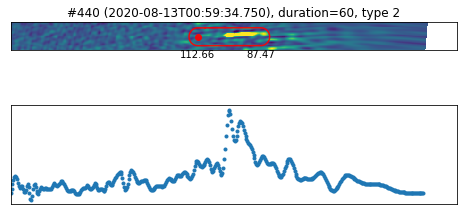

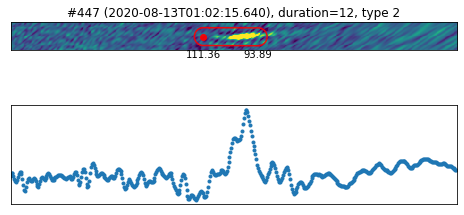

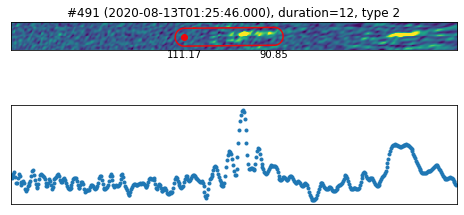

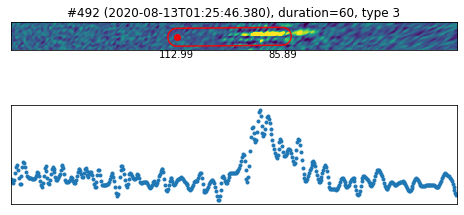

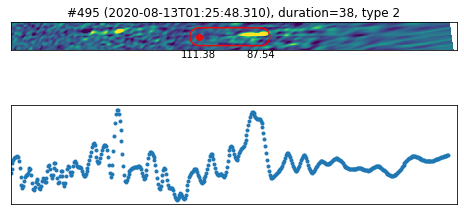

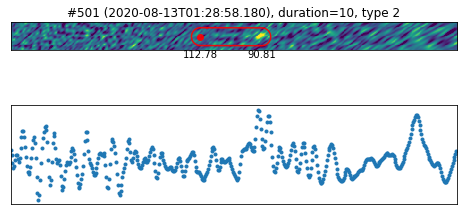

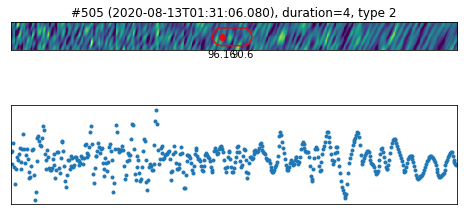

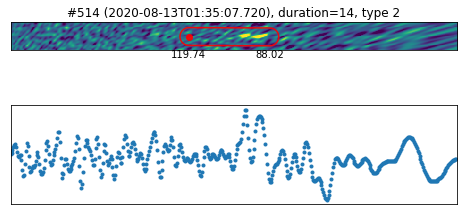

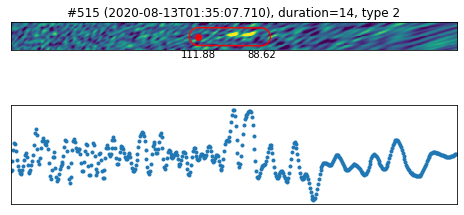

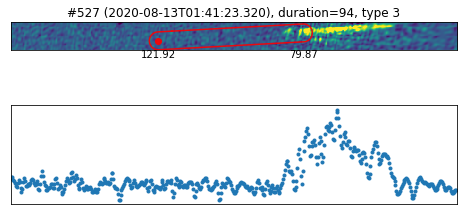

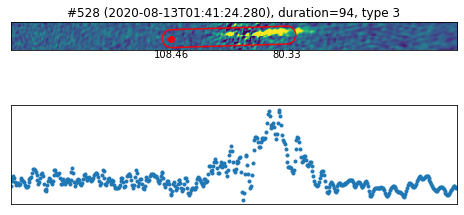

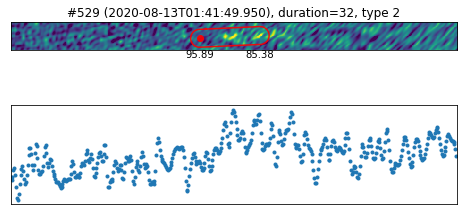

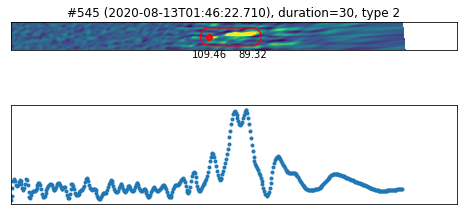

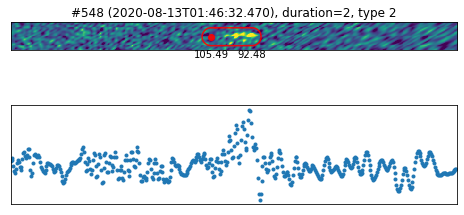

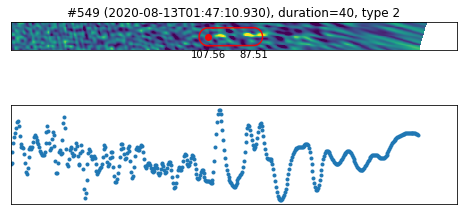

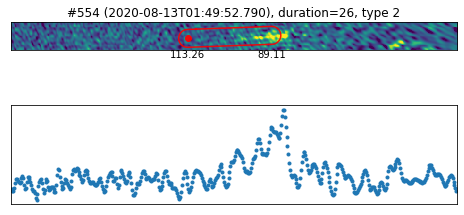

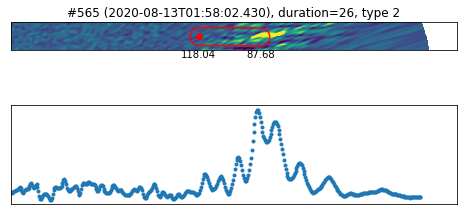

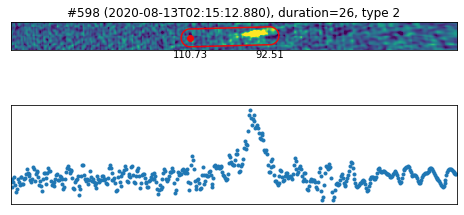

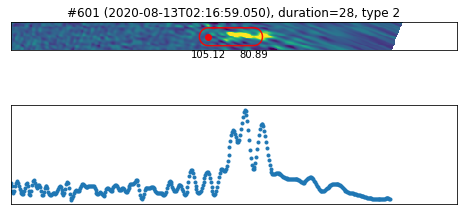

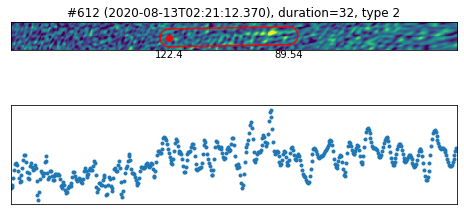

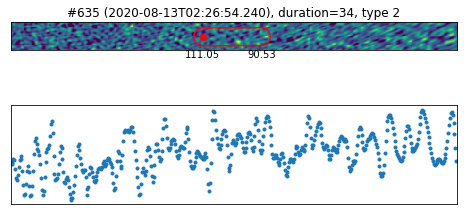

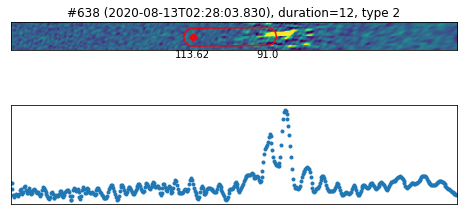

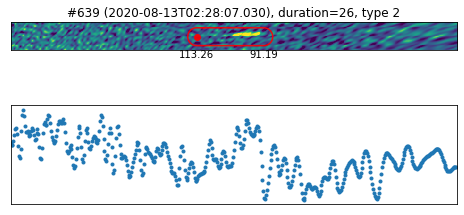

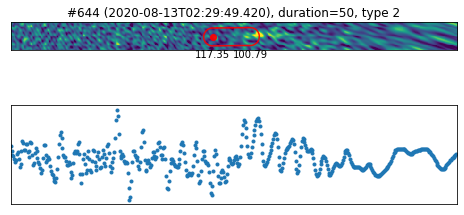

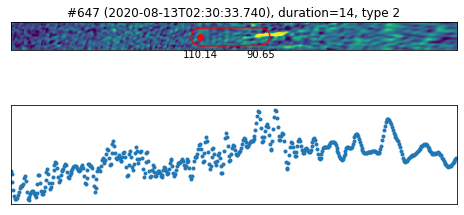

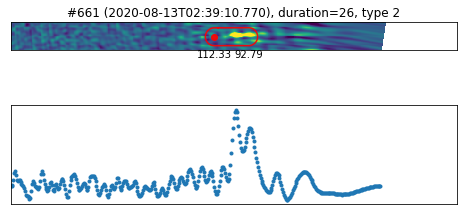

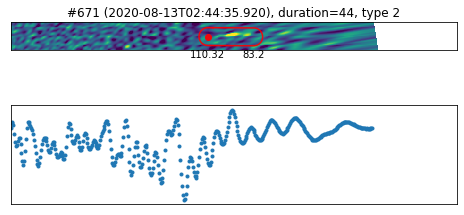

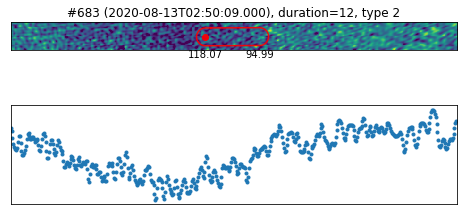

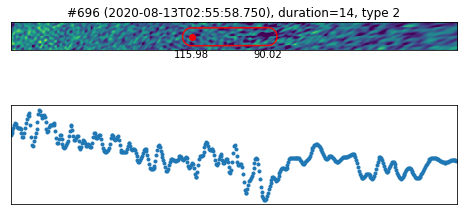

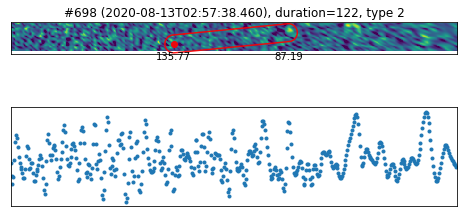

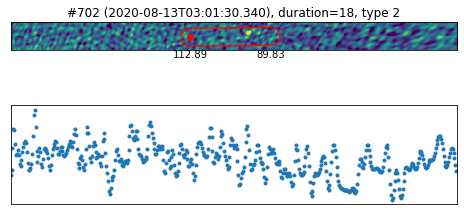

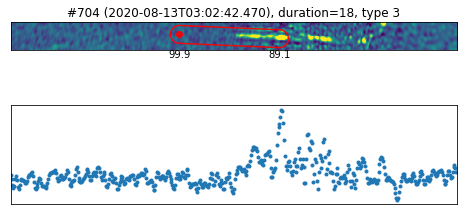

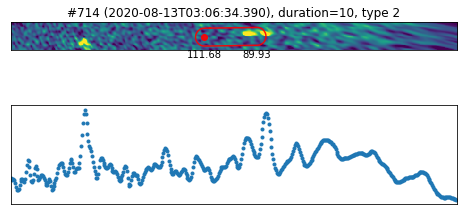

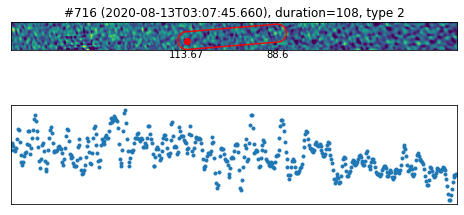

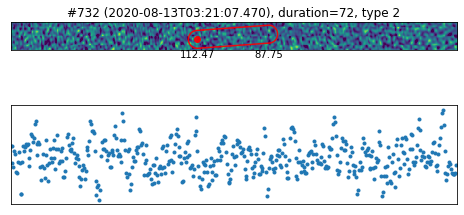

In [18]:
d_all = read_cams_observations("../SummaryMeteorLog CAMS Benelux 120820 .txt")

for number in tqdm(cams_numbers_with_trails):
    # Select meteor
    c = d_all["number"] == number
    d = d_all[c]
    
    if len(d) != 1:
        print("No match for cams number", number)
        continue
    
    t0 = Time(d["t0"], format="isot", scale="utc")
    
    #if np.any(aartfaac_cams_matches.loc[number]["AARTFAAC_duration"] > 8):
    #    extra = 1
    #else:
    #    extra = 0
    extra = 0
    try:
        fitsfile_before_detection, fitsfile_with_detection = get_fitsfiles(t0[0], extra)
    except:
        print("No good times around", t0)
        continue
    
    hdu = fits.open(fitsfile_with_detection)
    data = np.squeeze(hdu[0].data)
    header = hdu[0].header
    hdu.close()

    hdu = fits.open(fitsfile_before_detection)
    data = data - np.squeeze(hdu[0].data)
    hdu.close()

    # Construct trajectory
    dt = np.linspace(d["dtmin"], d["dtmax"], 10)
    x, y, z = d["x0"] + dt * d["vx"], d["y0"] + dt * d["vy"], d["z0"] + dt * d["vz"]
    g = GCRS(CartesianRepresentation(x=x * u.km, y=y * u.km, z=z * u.km), obstime=t0)

    # LOFAR location
    loc_lofar = EarthLocation(lat = 52.9153 * u.deg,
                              lon = 6.8698 * u.deg,
                              height = 0 * u.m)

    # Observe from LOFAR
    obsgeoloc, obsgeovel = loc_lofar.get_gcrs_posvel(obstime=t0)
    glofar = g.transform_to(GCRS(obstime=t0, obsgeoloc=obsgeoloc, obsgeovel=obsgeovel))
    p = SkyCoord(ra=glofar.ra.degree, dec=glofar.dec.degree, unit="deg")

    # Get extrema
    pmin, pmax, pmid = p[0].squeeze(), p[-1].squeeze(), p[len(p) // 2].squeeze()

    # Rotation angle
    ang = pmin.position_angle(pmax) - 90 * u.deg
    # print(ang.to(u.deg))

    # Data WCS
    oldwcs = wcs.WCS(header, naxis=2)

    # New image size
    nx, ny = 500, 31

    # Generate new WCS
    wnew = wcs.WCS(naxis=2)
    wnew.wcs.crval = np.array([pmid.ra.degree, pmid.dec.degree])
    wnew.wcs.crpix = np.array([nx / 2, ny / 2])
    wnew.wcs.cdelt = np.array([0.1, 0.1])
    wnew.wcs.pc = np.array([[np.cos(ang), np.sin(ang)],
                            [-np.sin(ang), np.cos(ang)]])
    wnew.wcs.ctype = ["RA---STG", "DEC--STG"]    

    # Reproject meteor
    v, footprint = reproject_interp((data, oldwcs), wnew, shape_out=(ny, nx))

    vmin = np.nanmean(v) - 2 * np.nanstd(v)
    vmax = np.nanmean(v) + 4 * np.nanstd(v)

    fig, [ax, ax2] = plt.subplots(2,1, figsize=(8, 4))

    ax.imshow(v, origin="lower", interpolation="None",
              vmin=vmin, vmax=vmax)

    # Plot meteor
    x, y = p.to_pixel(wnew)

    ax.plot(x[0], y[0], "ro", alpha=0.9)
    ax.plot(*(LineString(np.array([x.flatten(), y.flatten()]).T).buffer(10).exterior.xy), color="red", alpha=0.9)
#    ax.plot(x, y, "r", alpha=0.9)

    xmin, _ = pmin.to_pixel(wnew)
    ax.text(xmin, 0, camsdata.loc[number]["Hbeg km"],verticalalignment='top', horizontalalignment='center')
    
    xmax, _ = pmax.to_pixel(wnew)
    ax.text(xmax, 0, camsdata.loc[number]["Hend km"],verticalalignment='top', horizontalalignment='center')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f"#{number} ({t0[0]}), duration={camsdata.loc[number]['AARTFAAC_duration']:.0f}, type {camsdata.loc[number]['AARTFAAC']:.0f}")

    #plt.tight_layout()
    plt.savefig("plot.png", bbox_inches="tight")

    ax2.plot(np.mean(v, axis=0), '.');
    ax2.set_yticks([])
    ax2.margins(x=0)
    ax2.set_xlim(0, v.shape[-1])
    ax2.set_xticks([])
    
    plt.show()
    plt.close('all')